# Generative Adversarial Networks

In [160]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device is {device}")

device is cuda


## 1. Vanilla GAN

### 1.1 Generator Network

In [161]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_units, output_shape):
        super().__init__()

        self.model = nn.Sequential(nn.Linear(input_size, hidden_units),
                                   nn.LeakyReLU(0.01),
                                   nn.Linear(hidden_units, np.prod(output_shape)),
                                   nn.Tanh(),
                                   nn.Unflatten(1, output_shape))
        
    def forward(self, z):
        return self.model(z)

Generator(
  (model): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=784, bias=True)
    (3): Tanh()
    (4): Unflatten(dim=1, unflattened_size=(1, 28, 28))
  )
)
torch.Size([32, 1, 28, 28])


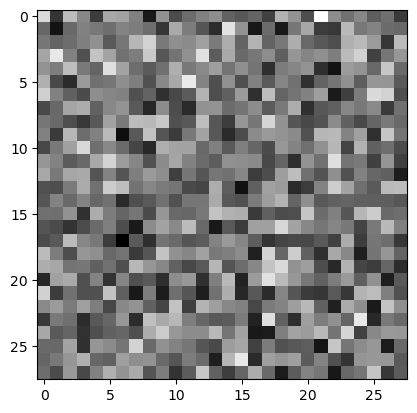

In [174]:
z = torch.randn(size=(32, 20), device=device)

output_shape = (1, 28, 28)

generator_test = Generator(input_size=20, hidden_units=100, output_shape=output_shape).to(device)

print(generator_test)

generator_test.eval()
with torch.inference_mode():
    generated_images = generator_test(z)
    print(generated_images.shape)
    plt.imshow(generated_images[0][0].cpu(),  cmap="gray")


### 1.2 Discriminator Network

In [163]:
class Discriminator(nn.Module):
    def __init__(self, input_shape, hidden_units):
        super().__init__()
        
        self.model = nn.Sequential(nn.Flatten(),
                                   nn.Linear(np.prod(input_shape), hidden_units),
                                   nn.LeakyReLU(0.01),
                                   nn.Dropout(0.5),
                                   nn.Linear(hidden_units, 1),
                                   nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

In [164]:
input_shape = generated_images[0].shape
discriminator_test = Discriminator(input_shape=input_shape, hidden_units=100).to(device)

print(discriminator_test)

discriminator_test.eval()
with torch.inference_mode():
    prob = discriminator_test(generated_images[0])
    print(prob)

Discriminator(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=100, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
tensor([[0.4850]], device='cuda:0')


### 1.3 Loading MNIST Dataset

In [165]:
image_path = "./"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)) # Normalize images pixels values to be rescaled in the range [-1, 1]
])

mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True,
    transform=transform, download=True
)

image, label = next(iter(mnist_dataset))
print(f"image shape: {image.shape} | image min value: {image.min()} | image max value: {image.max()}")

image shape: torch.Size([1, 28, 28]) | image min value: -1.0 | image max value: 1.0


In [166]:
def show_batches(batch, num_images=8, num_rows=2, num_cols=4):
    batch = batch.squeeze()
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(batch[i], cmap="gray")
        plt.axis(False)
    plt.show()

In [167]:
def create_noise(batch_size, noise_size, mode_noise, device):
    if mode_noise == 'uniform':
        input_z = torch.rand(size=(batch_size, noise_size), device=device) * 2 - 1
    elif mode_noise == 'normal':
        input_z = torch.randn(size=(batch_size, noise_size), device=device)
    return input_z

### 1.4 Creating Data Loader

noise vector shape: torch.Size([32, 20]) | real image shape: torch.Size([32, 1, 28, 28])


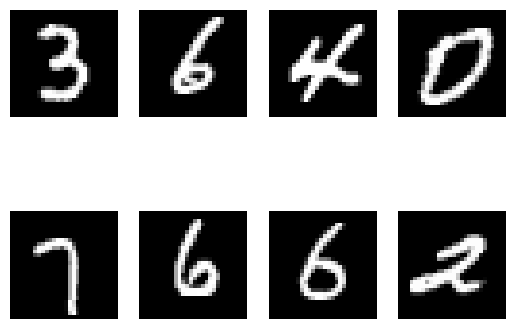

In [168]:
batch_size = 32
mode_noise = 'uniform'
noise_size = 20

data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

input_real, label = next(iter(data_loader))
# input_real = input_real.view(batch_size, -1)

input_z = create_noise(batch_size, noise_size, mode_noise, device=device)
print(f"noise vector shape: {input_z.shape} | real image shape: {input_real.shape}")
show_batches(input_real)

### 1.5 Defining hyperparameters, generator, discriminator, loss function and optimizers 

In [169]:
batch_size = 32
noise_size = 20
hidden_units = 100

torch.manual_seed(42)
np.random.seed(42)

mnist_dataloader = DataLoader(mnist_dataset, batch_size=batch_size,
                              shuffle=True, drop_last=True) # Drop Last parameter ignores the last batch

image_shape = next(iter(mnist_dataloader))[0][0].shape

generator = Generator(noise_size, hidden_units, image_shape).to(device)
discriminator = Discriminator(image_shape, hidden_units).to(device)

loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(params=generator.parameters())
d_optimizer = torch.optim.Adam(params=discriminator.parameters())

### 1.6 Training Loop

In [170]:
### Training the generative adversarial network
def train(dataloader:DataLoader, batch_size:int, discriminator:nn, genereator:nn, loss_fn:nn,
           g_optimizer:torch.optim.Optimizer, d_optimizer:torch.optim.Optimizer, device):
    
    valid_labels = torch.ones(size=(batch_size,1), device=device)
    fake_labels = torch.zeros(size=(batch_size,1), device=device)

    for i, batch in enumerate(dataloader):
        real_image, label = batch
        real_image = real_image.to(device)
        # print(real_image.shape)

        ## Training Discriminator
        discriminator.train()
        noise_vec = create_noise(batch_size, noise_size, mode_noise, device)
        fake_image = generator(noise_vec)

        # Forward pass
        d_prob_real = discriminator(real_image)
        d_prob_fake = discriminator(fake_image)

        # Calculate the loss
        d_loss_real = loss_fn(d_prob_real, valid_labels)
        d_loss_fake = loss_fn(d_prob_fake, fake_labels)
        d_loss = d_loss_fake + d_loss_real

        # Optimizer zero grad
        d_optimizer.zero_grad()

        # Loss backward
        d_loss.backward()

        # Optimizer step
        d_optimizer.step()

        ## Triaining Generator
        generator.train()

        # Forward pass
        noise_vec = create_noise(batch_size, noise_size, mode_noise, device)
        fake_image = generator(noise_vec)

        # Calculate the loss
        g_prob_fake = discriminator(fake_image)
        g_loss = loss_fn(g_prob_fake, valid_labels)

        # Optimizer zero grad
        g_optimizer.zero_grad()

        # Loss backward
        g_loss.backward()

        # Optimizer step
        g_optimizer.step()
        
        if (i+1)%500 == 0: 
            print(f"Batch: {i+1}/{len(dataloader)} | Discriminator Loss: {d_loss} | Generator Loss: {g_loss}")
    return (d_loss_real, d_loss_fake, d_loss, g_loss)


Epoch: 1
Batch: 500/1875 | Discriminator Loss: 0.9552165269851685 | Generator Loss: 0.8729935884475708
Batch: 1000/1875 | Discriminator Loss: 1.2193591594696045 | Generator Loss: 0.662592887878418
Batch: 1500/1875 | Discriminator Loss: 1.2986234426498413 | Generator Loss: 1.0516884326934814

Epoch: 2
Batch: 500/1875 | Discriminator Loss: 1.0735599994659424 | Generator Loss: 0.9756653904914856
Batch: 1000/1875 | Discriminator Loss: 1.0132169723510742 | Generator Loss: 0.9705401062965393
Batch: 1500/1875 | Discriminator Loss: 1.267822027206421 | Generator Loss: 1.2725465297698975

Epoch: 3
Batch: 500/1875 | Discriminator Loss: 1.3575851917266846 | Generator Loss: 0.8576365113258362
Batch: 1000/1875 | Discriminator Loss: 1.182651400566101 | Generator Loss: 0.8732077479362488
Batch: 1500/1875 | Discriminator Loss: 1.1537144184112549 | Generator Loss: 0.8772668838500977

Epoch: 4
Batch: 500/1875 | Discriminator Loss: 1.1719833612442017 | Generator Loss: 0.7751407623291016
Batch: 1000/1875 

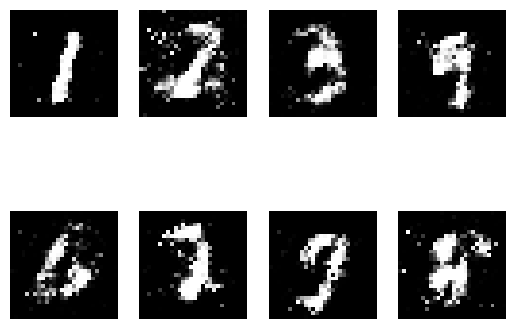


Epoch: 11
Batch: 500/1875 | Discriminator Loss: 1.3128077983856201 | Generator Loss: 0.9305917024612427
Batch: 1000/1875 | Discriminator Loss: 1.2655208110809326 | Generator Loss: 0.8566684722900391
Batch: 1500/1875 | Discriminator Loss: 1.2508188486099243 | Generator Loss: 0.984367311000824

Epoch: 12
Batch: 500/1875 | Discriminator Loss: 1.3686633110046387 | Generator Loss: 1.0285247564315796
Batch: 1000/1875 | Discriminator Loss: 1.2920231819152832 | Generator Loss: 0.8163120746612549
Batch: 1500/1875 | Discriminator Loss: 1.278073787689209 | Generator Loss: 0.8796244859695435

Epoch: 13
Batch: 500/1875 | Discriminator Loss: 1.2903897762298584 | Generator Loss: 0.9212591052055359
Batch: 1000/1875 | Discriminator Loss: 1.1758346557617188 | Generator Loss: 0.8152614831924438
Batch: 1500/1875 | Discriminator Loss: 1.220676064491272 | Generator Loss: 0.7465869188308716

Epoch: 14
Batch: 500/1875 | Discriminator Loss: 1.350679874420166 | Generator Loss: 0.8136699199676514
Batch: 1000/18

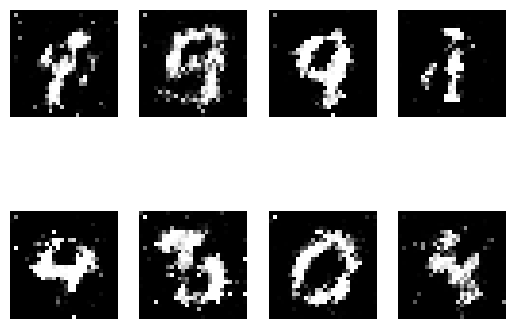


Epoch: 21
Batch: 500/1875 | Discriminator Loss: 1.462148904800415 | Generator Loss: 0.80156409740448
Batch: 1000/1875 | Discriminator Loss: 1.3019928932189941 | Generator Loss: 0.7476503849029541
Batch: 1500/1875 | Discriminator Loss: 1.3253841400146484 | Generator Loss: 0.7270382642745972

Epoch: 22
Batch: 500/1875 | Discriminator Loss: 1.3294810056686401 | Generator Loss: 0.9813908338546753
Batch: 1000/1875 | Discriminator Loss: 1.2044141292572021 | Generator Loss: 0.824228048324585
Batch: 1500/1875 | Discriminator Loss: 1.2807066440582275 | Generator Loss: 0.9132938385009766

Epoch: 23
Batch: 500/1875 | Discriminator Loss: 1.402212381362915 | Generator Loss: 0.91280198097229
Batch: 1000/1875 | Discriminator Loss: 1.275705337524414 | Generator Loss: 0.8987499475479126
Batch: 1500/1875 | Discriminator Loss: 1.312401294708252 | Generator Loss: 0.6781837940216064

Epoch: 24
Batch: 500/1875 | Discriminator Loss: 1.3106826543807983 | Generator Loss: 0.7661617994308472
Batch: 1000/1875 | 

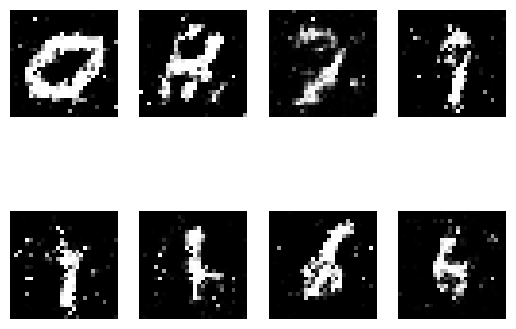


Epoch: 31
Batch: 500/1875 | Discriminator Loss: 1.402724027633667 | Generator Loss: 0.8322342038154602
Batch: 1000/1875 | Discriminator Loss: 1.328357458114624 | Generator Loss: 0.7569749355316162
Batch: 1500/1875 | Discriminator Loss: 1.3189072608947754 | Generator Loss: 0.7825011014938354

Epoch: 32
Batch: 500/1875 | Discriminator Loss: 1.3542017936706543 | Generator Loss: 0.7342187166213989
Batch: 1000/1875 | Discriminator Loss: 1.400503158569336 | Generator Loss: 0.8372175693511963
Batch: 1500/1875 | Discriminator Loss: 1.4143348932266235 | Generator Loss: 0.7242276668548584

Epoch: 33
Batch: 500/1875 | Discriminator Loss: 1.265892505645752 | Generator Loss: 0.6714251041412354
Batch: 1000/1875 | Discriminator Loss: 1.2965823411941528 | Generator Loss: 0.794062614440918
Batch: 1500/1875 | Discriminator Loss: 1.2290656566619873 | Generator Loss: 0.6594127416610718

Epoch: 34
Batch: 500/1875 | Discriminator Loss: 1.346753716468811 | Generator Loss: 0.7955492734909058
Batch: 1000/1875

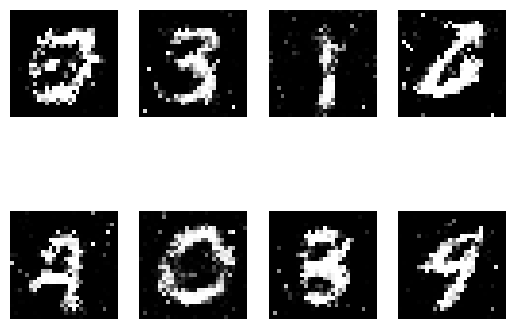


Epoch: 41
Batch: 500/1875 | Discriminator Loss: 1.3631725311279297 | Generator Loss: 0.7691643238067627
Batch: 1000/1875 | Discriminator Loss: 1.237742304801941 | Generator Loss: 0.7200739979743958
Batch: 1500/1875 | Discriminator Loss: 1.343963861465454 | Generator Loss: 0.8182557821273804

Epoch: 42
Batch: 500/1875 | Discriminator Loss: 1.3778014183044434 | Generator Loss: 0.7485922574996948
Batch: 1000/1875 | Discriminator Loss: 1.3206186294555664 | Generator Loss: 0.7100523710250854
Batch: 1500/1875 | Discriminator Loss: 1.2100927829742432 | Generator Loss: 0.8507362604141235

Epoch: 43
Batch: 500/1875 | Discriminator Loss: 1.327127456665039 | Generator Loss: 0.9218360185623169
Batch: 1000/1875 | Discriminator Loss: 1.3245394229888916 | Generator Loss: 0.8060376644134521
Batch: 1500/1875 | Discriminator Loss: 1.4464216232299805 | Generator Loss: 0.8373273015022278

Epoch: 44
Batch: 500/1875 | Discriminator Loss: 1.3490419387817383 | Generator Loss: 0.7607688307762146
Batch: 1000/1

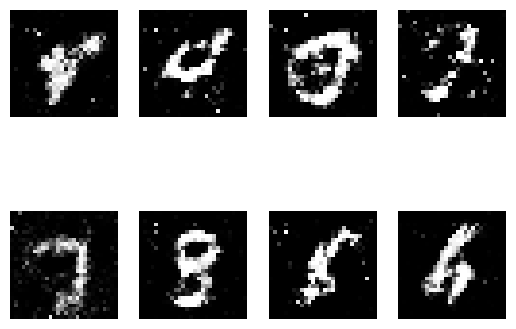


Epoch: 51
Batch: 500/1875 | Discriminator Loss: 1.445055365562439 | Generator Loss: 0.7042297720909119
Batch: 1000/1875 | Discriminator Loss: 1.3409667015075684 | Generator Loss: 0.7182689905166626
Batch: 1500/1875 | Discriminator Loss: 1.3905216455459595 | Generator Loss: 0.8025912046432495

Epoch: 52
Batch: 500/1875 | Discriminator Loss: 1.3152830600738525 | Generator Loss: 0.8058456778526306
Batch: 1000/1875 | Discriminator Loss: 1.2387632131576538 | Generator Loss: 0.8429204225540161
Batch: 1500/1875 | Discriminator Loss: 1.350717544555664 | Generator Loss: 0.7383610010147095

Epoch: 53
Batch: 500/1875 | Discriminator Loss: 1.385956048965454 | Generator Loss: 0.8777492046356201
Batch: 1000/1875 | Discriminator Loss: 1.3161433935165405 | Generator Loss: 0.8173196911811829
Batch: 1500/1875 | Discriminator Loss: 1.267552375793457 | Generator Loss: 0.7444179058074951

Epoch: 54
Batch: 500/1875 | Discriminator Loss: 1.3451796770095825 | Generator Loss: 0.8062070608139038
Batch: 1000/18

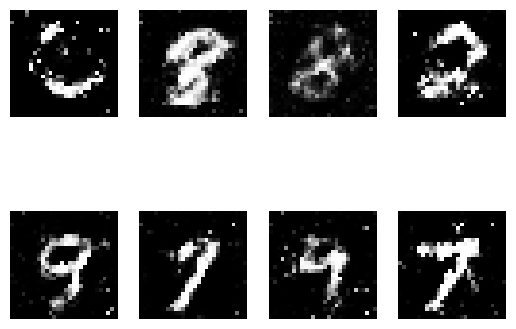


Epoch: 61
Batch: 500/1875 | Discriminator Loss: 1.3284295797348022 | Generator Loss: 0.7906609773635864
Batch: 1000/1875 | Discriminator Loss: 1.2500197887420654 | Generator Loss: 0.9486097693443298
Batch: 1500/1875 | Discriminator Loss: 1.3411338329315186 | Generator Loss: 0.8064919710159302

Epoch: 62
Batch: 500/1875 | Discriminator Loss: 1.284946322441101 | Generator Loss: 0.8659894466400146
Batch: 1000/1875 | Discriminator Loss: 1.3487036228179932 | Generator Loss: 0.8032141923904419
Batch: 1500/1875 | Discriminator Loss: 1.3116154670715332 | Generator Loss: 0.7847599983215332

Epoch: 63
Batch: 500/1875 | Discriminator Loss: 1.3606696128845215 | Generator Loss: 0.7141340374946594
Batch: 1000/1875 | Discriminator Loss: 1.3678845167160034 | Generator Loss: 0.863877534866333
Batch: 1500/1875 | Discriminator Loss: 1.3730332851409912 | Generator Loss: 0.8221427798271179

Epoch: 64
Batch: 500/1875 | Discriminator Loss: 1.2800859212875366 | Generator Loss: 0.7152718305587769
Batch: 1000/

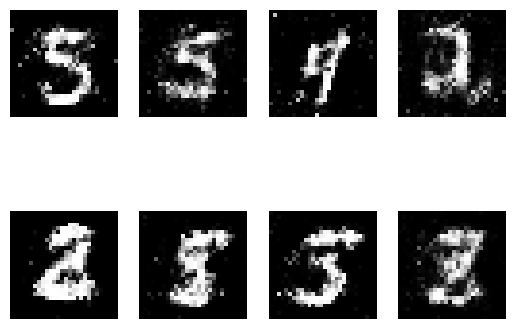


Epoch: 71
Batch: 500/1875 | Discriminator Loss: 1.257170557975769 | Generator Loss: 0.7983588576316833
Batch: 1000/1875 | Discriminator Loss: 1.3792179822921753 | Generator Loss: 0.6557581424713135
Batch: 1500/1875 | Discriminator Loss: 1.2910618782043457 | Generator Loss: 0.8583515882492065

Epoch: 72
Batch: 500/1875 | Discriminator Loss: 1.2051396369934082 | Generator Loss: 0.8657332062721252
Batch: 1000/1875 | Discriminator Loss: 1.1263002157211304 | Generator Loss: 0.7901894450187683
Batch: 1500/1875 | Discriminator Loss: 1.307776689529419 | Generator Loss: 0.7912652492523193

Epoch: 73
Batch: 500/1875 | Discriminator Loss: 1.252092719078064 | Generator Loss: 0.8709931373596191
Batch: 1000/1875 | Discriminator Loss: 1.3805127143859863 | Generator Loss: 0.7189295887947083
Batch: 1500/1875 | Discriminator Loss: 1.3221153020858765 | Generator Loss: 0.7062009572982788

Epoch: 74
Batch: 500/1875 | Discriminator Loss: 1.2513580322265625 | Generator Loss: 0.8722107410430908
Batch: 1000/1

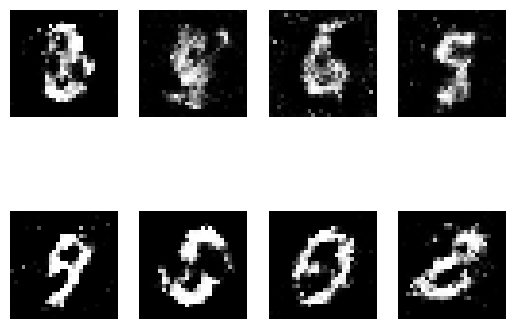


Epoch: 81
Batch: 500/1875 | Discriminator Loss: 1.478653907775879 | Generator Loss: 0.7342482209205627
Batch: 1000/1875 | Discriminator Loss: 1.423854947090149 | Generator Loss: 0.8313646912574768
Batch: 1500/1875 | Discriminator Loss: 1.2592260837554932 | Generator Loss: 0.8787915706634521

Epoch: 82
Batch: 500/1875 | Discriminator Loss: 1.3760511875152588 | Generator Loss: 0.9416201710700989
Batch: 1000/1875 | Discriminator Loss: 1.3177862167358398 | Generator Loss: 0.7568795084953308
Batch: 1500/1875 | Discriminator Loss: 1.206918478012085 | Generator Loss: 0.822996973991394

Epoch: 83
Batch: 500/1875 | Discriminator Loss: 1.266191005706787 | Generator Loss: 0.7518399953842163
Batch: 1000/1875 | Discriminator Loss: 1.3973710536956787 | Generator Loss: 0.8028212785720825
Batch: 1500/1875 | Discriminator Loss: 1.291975498199463 | Generator Loss: 0.7694534063339233

Epoch: 84
Batch: 500/1875 | Discriminator Loss: 1.2995758056640625 | Generator Loss: 0.7928335666656494
Batch: 1000/1875

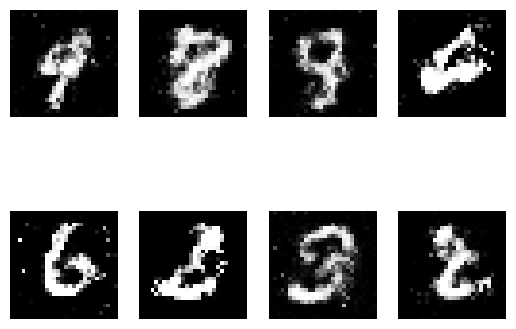


Epoch: 91
Batch: 500/1875 | Discriminator Loss: 1.401578426361084 | Generator Loss: 0.8703175783157349
Batch: 1000/1875 | Discriminator Loss: 1.3490593433380127 | Generator Loss: 0.7943049669265747
Batch: 1500/1875 | Discriminator Loss: 1.3276563882827759 | Generator Loss: 0.792826235294342

Epoch: 92
Batch: 500/1875 | Discriminator Loss: 1.37526535987854 | Generator Loss: 0.8323956727981567
Batch: 1000/1875 | Discriminator Loss: 1.2635960578918457 | Generator Loss: 0.8065714836120605
Batch: 1500/1875 | Discriminator Loss: 1.3119444847106934 | Generator Loss: 0.7578169107437134

Epoch: 93
Batch: 500/1875 | Discriminator Loss: 1.286078929901123 | Generator Loss: 0.7924693822860718
Batch: 1000/1875 | Discriminator Loss: 1.166115164756775 | Generator Loss: 0.8799241781234741
Batch: 1500/1875 | Discriminator Loss: 1.3425084352493286 | Generator Loss: 0.9102500677108765

Epoch: 94
Batch: 500/1875 | Discriminator Loss: 1.2568533420562744 | Generator Loss: 0.7764782905578613
Batch: 1000/1875

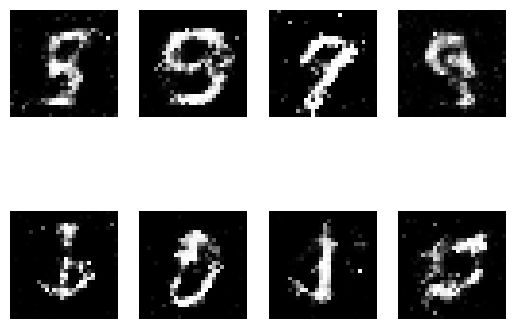

In [171]:
# Training for number of epochs
num_epochs = 100

all_d_fake_losses = []
all_d_real_losses = []
all_d_losses = []
all_g_losses = []

for epoch in range(num_epochs):
    print(f"\nEpoch: {epoch+1}")
    d_loss_real, d_loss_fake, d_loss, g_loss = train(dataloader=data_loader, batch_size=32,
          discriminator=discriminator, genereator=generator,
          loss_fn=loss_fn, g_optimizer=g_optimizer, d_optimizer=d_optimizer,
          device=device)
    
    all_d_real_losses.append(d_loss_real.cpu().detach().numpy())
    all_d_fake_losses.append(d_loss_fake.cpu().detach().numpy())
    all_d_losses.append(d_loss.cpu().detach().numpy())
    all_g_losses.append(g_loss.cpu().detach().numpy())

    ## Evaluation
    if (epoch+1) % 10 == 0:
        generator.eval()
        with torch.inference_mode():
            noise_vec = create_noise(batch_size, noise_size, mode_noise, device)
            fake_images = generator(noise_vec)
            show_batches(fake_images.cpu(), num_images=8, num_cols=4, num_rows=2)
          

### 1.7 Plotting losses for generator and discriminator

[array(1.0214857, dtype=float32), array(1.4723613, dtype=float32), array(0.87690353, dtype=float32), array(1.2826431, dtype=float32), array(0.9462163, dtype=float32), array(1.2077174, dtype=float32), array(1.3053267, dtype=float32), array(1.3967377, dtype=float32), array(1.2323732, dtype=float32), array(0.897613, dtype=float32), array(0.79710877, dtype=float32), array(0.84110117, dtype=float32), array(0.81569767, dtype=float32), array(0.7608496, dtype=float32), array(0.8604691, dtype=float32), array(0.77783823, dtype=float32), array(0.9616674, dtype=float32), array(0.7753359, dtype=float32), array(0.709204, dtype=float32), array(0.7444771, dtype=float32), array(0.74198943, dtype=float32), array(0.7608273, dtype=float32), array(0.7084888, dtype=float32), array(0.76479447, dtype=float32), array(0.8042002, dtype=float32), array(0.7372617, dtype=float32), array(0.7230286, dtype=float32), array(0.8048558, dtype=float32), array(0.69062495, dtype=float32), array(0.72493553, dtype=float32), ar

Text(0, 0.5, 'Loss')

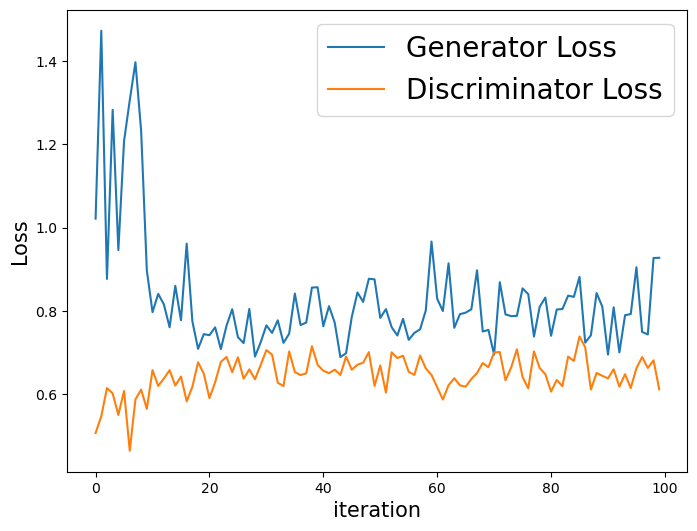

In [172]:
# Ploting losses
all_g_losses = [all_g_loss for all_g_loss in all_g_losses]
print(all_g_losses)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(all_g_losses, label='Generator Loss')

half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator Loss')

plt.legend(fontsize=20)
ax.set_xlabel('iteration', size=15)
ax.set_ylabel('Loss', size=15)

### 1.8 Saving the learned model

In [173]:
# Save the model

from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path for generator and discriminator models
MODEL_NAME_G = "01_generator.pth" #files most be saved with the extension of either .pth or .pt
MODEL_NAME_D = "01_discriminator.pth"

MODEL_SAVE_PATH_G = MODEL_PATH / MODEL_NAME_G
MODEL_SAVE_PATH_D = MODEL_PATH / MODEL_NAME_D

# Save models state_dict()
print(f"Saving model to: {MODEL_SAVE_PATH_G}")
torch.save(obj=generator.state_dict(), f=MODEL_SAVE_PATH_G)

print(f"Saving model to: {MODEL_SAVE_PATH_D}")
torch.save(obj=discriminator.state_dict(), f=MODEL_SAVE_PATH_D)

Saving model to: models\01_generator.pth
Saving model to: models\01_discriminator.pth
